```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook is used to test external boundary conditions.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [26]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
#rc('animation', html='html5')
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'serif'

#Import our simulator
from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, WindStress, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

In [2]:
import importlib

In [3]:
%setup_logging -o bc_test.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger using level DEBUG to bc_test.log
Python version 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Registering gpu_ctx in user workspace
PyCUDA version 2019.1.2
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <94889550497712>


In [4]:
#Set this to false before comitting to only get images
create_movie = False

In [27]:
def sim_animation(simulator, t_end, T=100, 
                 h_min=-1.5, h_max=1.5, 
                 uv_min=-0.05, uv_max=0.05, 
                 interior_domain_only=True,
                 create_movie=True, fig=None,
                 filename=None):
    if (create_movie == False):
        simulator.step(t_end / 2)
        
    eta1, u1, v1 = sim.download(interior_domain_only=interior_domain_only)
    Hi, Hm = sim.downloadBathymetry(interior_domain_only=interior_domain_only)
    
    def genVelocity(rho, rho_u, rho_v):
        u = rho_u / rho
        v = rho_v / rho
        u = np.sqrt(u**2 + v**2)

        return u


    def genVorticity(rho, rho_u, rho_v):
        u = rho_u / rho
        v = rho_v / rho
        u = np.sqrt(u**2 + v**2)
        u_max = u.max()

        du_dy, _ = np.gradient(u)
        _, dv_dx = np.gradient(v)

        #Length of curl
        curl = dv_dx - du_dy
        return curl


    def genColors(rho, rho_u, rho_v, cmap, vmin, vmax):
        curl = genVorticity(rho, rho_u, rho_v)

        colors = Normalize(vmin, vmax, clip=True)(curl)
        colors = cmap(colors)

        return colors
    
    
    #Create figure and plot initial conditions
    if (fig is None):
        fig = plt.figure(figsize=(12, 8))
    domain_extent = [0, sim.nx*sim.dx / 1000, 0, sim.ny*sim.dy / 1000]
    
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta1, interpolation="none", origin='bottom', cmap=plt.cm.coolwarm, vmin=h_min, vmax=h_max, extent=domain_extent)
    
    ax_u = plt.subplot(1,3,2)
    V = genVelocity(Hm+eta1, u1, v1)
    sp_u = ax_u.imshow(V, interpolation="none", origin='bottom', cmap=plt.cm.Oranges, vmin=0, vmax=(uv_max-uv_min), extent=domain_extent)
    
    ax_v = plt.subplot(1,3,3)
    R = genColors(Hm+eta1, u1, v1, plt.cm.seismic, uv_min, uv_max)
    sp_v = ax_v.imshow(R, interpolation="none", origin='bottom', extent=domain_extent)
    
    t_per_plot = t_end / T
    
    
    #Helper function which simulates and plots the solution
    def animate(i):
        if (i>0):
            t = sim.step(t_per_plot)
        else:
            t = 0.0
        eta1, u1, v1 = sim.download(interior_domain_only=interior_domain_only)
        
        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)
        
        fig.sca(ax_u)
        V = genVelocity(Hm+eta1, u1, v1)
        sp_u.set_data(V)
        
        fig.sca(ax_v)
        R = genColors(Hm+eta1, u1, v1, plt.cm.seismic, uv_min, uv_max)
        sp_v.set_data(R)
        
        fig.suptitle("Time = {:04.0f} s ({:s})".format(t, sim.__class__.__name__), fontsize=18)
        print(".", end='')

    #Matplotlib for creating an animation
    if (create_movie):
        anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
        plt.close(fig)
        return anim
    else:
        if (filename is not None):
            plt.savefig(filename + ".pdf")
        pass


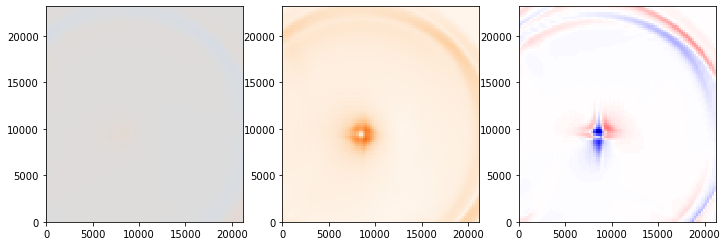

In [6]:
importlib.reload(Common)
importlib.reload(CDKLM16)


# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 90, "ny": 100,
    "dx": 200.0, "dy": 200.0,
    "dt": 1.0,
    "g": 9.81,
    "f": 0.0012,
    "coriolis_beta": 1.0e-6,
    "r": 0.0,
    "rk_order": 2
}
sponge_cells=[10, 10, 10, 10]
bc_len = 20
H_max = 60

t = []
h = []
hu = []
hv = []


t = [0]
    
h_north=[np.ones((1, 10), dtype=np.float32)*0]
h_south=[np.ones_like(h_north[0])*0]
h_east=[np.ones((3, 1), dtype=np.float32)*0]
h_west=[np.ones_like(h_east[0])*0]

hu_north = [np.ones_like(h_north[0])*0]
hu_south = [np.ones_like(h_south[0])*0]
hu_east = [np.ones_like(h_east[0])*0]
hu_west = [np.ones_like(h_west[0])*0]

hv_north = [np.ones_like(h_north[0])*0]
hv_south = [np.ones_like(h_south[0])*0]
hv_east = [np.ones_like(h_east[0])*0]
hv_west = [np.ones_like(h_west[0])*0]

boundary_conditions = Common.BoundaryConditions(3,3,3,3, spongeCells=sponge_cells)

bc_north = Common.SingleBoundaryConditionData(h_north, hu_north, hv_north);
bc_south = Common.SingleBoundaryConditionData(h_south, hu_south, hv_south);
bc_east = Common.SingleBoundaryConditionData(h_east, hu_east, hv_east);
bc_west = Common.SingleBoundaryConditionData(h_west, hu_west, hv_west);
boundary_conditions_data = Common.BoundaryConditionsData(t, bc_north, bc_south, bc_east, bc_west)

dataShape = (sim_args['ny'] + sponge_cells[0]+sponge_cells[2], 
             sim_args['nx'] + sponge_cells[1]+sponge_cells[3])
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_max
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)
#addCentralBump(eta0, sim_args['nx'], sim_args['ny'], sim_args['dx'], sim_args['dy'], sponge_cells)
addBump(eta0, sim_args['nx'], sim_args['ny'], sim_args['dx'], sim_args['dy'],
        0.4,0.4, 1, sponge_cells)

#Initialize simulator
data_args = {"H": H, 
             "eta0": eta0, 
             "hu0": u0, 
             "hv0": v0,
             "boundary_conditions": boundary_conditions,
             "boundary_conditions_data": boundary_conditions_data
            }

sim = CDKLM16.CDKLM16(**sim_args, **data_args)

#Run a simulation and plot it
sim_animation(sim, t_end=1000, T=50, h_max=0.25, h_min=-0.25, uv_max=0.01, uv_min=-0.01, create_movie=create_movie)

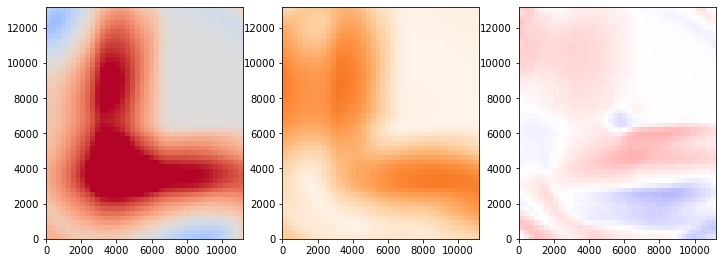

In [7]:
importlib.reload(Common)
importlib.reload(CDKLM16)

# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 40, "ny": 50,
    "dx": 200.0, "dy": 200.0,
    "dt": 1.0,
    "g": 9.81,
    "f": 0.0012,
    #"f": 0.0,
    "coriolis_beta": 1.0e-6,
    "r": 0.0,
    "rk_order": 1
}
sponge_cells=[10, 10, 10, 10]
bc_len = 20
H_max = 60

t = [0*sim_args['dt'], 100*sim_args['dt'], 200*sim_args['dt']]


x0 = np.linspace(0, 1, 100).reshape((1, 100)).astype(np.float32)
x1 = np.zeros_like(x0)
y0 = np.linspace(0, 1, 50).reshape((50, 1)).astype(np.float32)
y1 = np.zeros_like(y0)

x_a = [x1, x0, x1]
x_b = [x0, x1, x0]
x_null = [x1, x1, x1]

y_a = [y1, y0, y1]
y_b = [y0, y1, y0]
y_null = [y1, y1, y1]

h_north = x_null
h_south = x_a
h_east = y_null
h_west = y_a

hu_north = x_null
hu_south = x_null
hu_east = y_null
hu_west = y_null

hv_north = x_null
hv_south = x_null
hv_east = y_null
hv_west = y_null

boundary_conditions = Common.BoundaryConditions(3,3,3,3, spongeCells=sponge_cells)

bc_north = Common.SingleBoundaryConditionData(h_north, hu_north, hv_north);
bc_south = Common.SingleBoundaryConditionData(h_south, hu_south, hv_south);
bc_east = Common.SingleBoundaryConditionData(h_east, hu_east, hv_east);
bc_west = Common.SingleBoundaryConditionData(h_west, hu_west, hv_west);
boundary_conditions_data = Common.BoundaryConditionsData(t, bc_north, bc_south, bc_east, bc_west)

dataShape = (sim_args['ny'] + sponge_cells[0]+sponge_cells[2], 
             sim_args['nx'] + sponge_cells[1]+sponge_cells[3])
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_max
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)
addCentralBump(eta0, sim_args['nx'], sim_args['ny'], sim_args['dx'], sim_args['dy'], sponge_cells)

#Initialize simulator
data_args = {"H": H, 
              "eta0": eta0, 
             "hu0": u0, 
             "hv0": v0,
             "boundary_conditions": boundary_conditions,
             "boundary_conditions_data": boundary_conditions_data
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)


def plot(t, eta1, u1, v1):
    plt.figure(figsize=(16, 12))
    plt.title(str(t))
    plt.subplot(1,3,1)
    plt.imshow(eta1, origin='lower')
    plt.colorbar(shrink=0.4)
    plt.subplot(1,3,2)
    plt.imshow(u1, origin='lower')
    plt.colorbar(shrink=0.4)
    plt.subplot(1,3,3)
    plt.imshow(v1, origin='lower')
    plt.colorbar(shrink=0.4)

    """
    plt.figure(figsize=(16, 12))
    plt.subplot(2,3,1)
    plt.plot(eta1[:,0], label='eta')
    plt.plot(u1[:,0], label='hu')
    plt.plot(v1[:,0], label='hv')
    plt.legend()

    plt.subplot(2,3,2)
    plt.plot(eta1[:,eta1.shape[1]//2])
    plt.plot(v1[:,eta1.shape[1]//2])
    plt.plot(v1[:,eta1.shape[1]//2])

    plt.subplot(2,3,3)
    plt.plot(eta1[:,-1])
    plt.plot(v1[:,-1])
    plt.plot(v1[:,-1])


    plt.subplot(2,3,4)
    plt.plot(eta1[0,:])
    plt.plot(u1[0,:])
    plt.plot(v1[0,:])

    plt.subplot(2,3,5)
    plt.plot(eta1[eta1.shape[0]//2,:])
    plt.plot(u1[eta1.shape[0]//2,:])
    plt.plot(v1[eta1.shape[0]//2,:])

    plt.subplot(2,3,6)
    plt.plot(eta1[-1,:])
    plt.plot(u1[-1,:])
    plt.plot(v1[-1,:])
    """


#for i in range(10):
#    t = sim.step(50.0*sim_args['dt'])
#    eta1, u1, v1 = sim.download(interior_domain_only=False)
#    plot(t, eta1, u1, v1)

sim_animation(sim, t_end=500.0*sim_args['dt'], T=10, h_max=0.25, h_min=-0.25, uv_max=0.1, uv_min=-0.1, create_movie=create_movie)

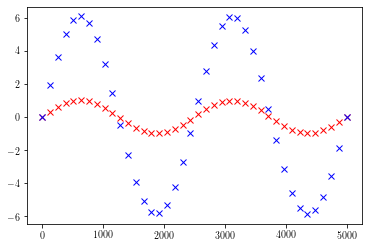

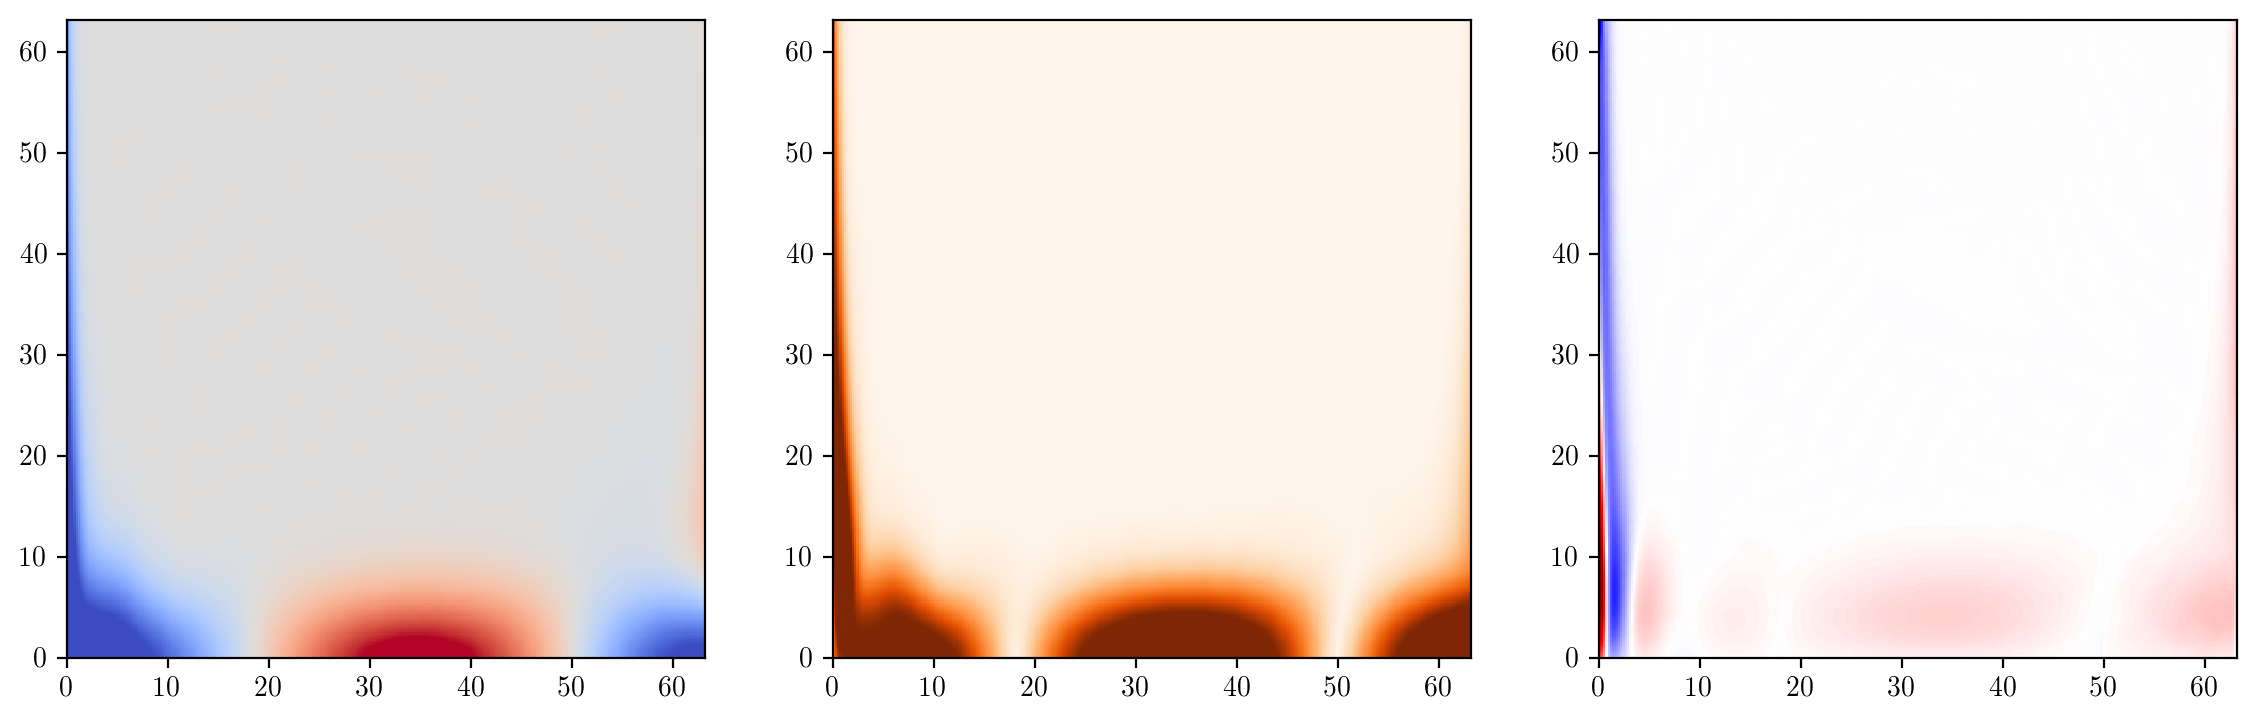

In [28]:
importlib.reload(Common)
importlib.reload(CDKLM16)

# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 300, "ny": 300,
    "dx": 200.0, "dy": 200.0,
    "dt": 1.0,
    "g": 9.81,
    "f": 0.0012,
    "coriolis_beta": 1.0e-6,
    #"f": 0.0,
    "r": 0.0,
    "rk_order": 2
}
sponge_cells=[10, 10, 10, 10]
bc_len = 40
H_max = 60

t = []
h_ns = []
hu_ns = []
hv_ns = []

h_ew = []
hu_ew = []
hv_ew = []


plt.figure()
t_end = 5000
for i in range(bc_len):
    j = i / (bc_len-1)

    eps = np.ones((1, 2), dtype=np.float32)*np.sin(4*np.pi*j)
    #eps[0, 1] = eps[0, 1] * 0.2;
    zero = np.zeros((1, 2), dtype=np.float32)

    t = t + [500+j*t_end]
    h_ns = h_ns + [eps]
    h_ew = h_ew + [np.transpose(eps)]
    
    hu_ns = hu_ns + [eps*0.1*(H_max+eps)]
    hu_ew = hu_ew + [np.transpose(eps)*0.1*(H_max+np.transpose(eps))]
    
    hv_ns = hv_ns + [eps*0.1*(H_max+eps)]
    hv_ew = hv_ew + [np.transpose(eps)*0.1*(H_max+np.transpose(eps))]
    
    plt.plot(j*t_end, h_ew[-1][0, 0], 'rx')
    plt.plot(j*t_end, hu_ew[-1][0, 0], 'bx')
plt.show()

h_north = [np.zeros((1, 2), dtype=np.float32)]*bc_len
h_south = [np.zeros((1, 2), dtype=np.float32)]*bc_len
h_east = [np.zeros((2, 1), dtype=np.float32)]*bc_len
h_west = h_ew

hu_north = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hu_south = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hu_east = hu_ew
hu_west = hu_ew

hv_north = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hv_south = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hv_east = [np.zeros((2, 1), dtype=np.float32)]*bc_len
hv_west = [np.zeros((2, 1), dtype=np.float32)]*bc_len

boundary_conditions = Common.BoundaryConditions(north=1,south=1,east=3,west=3, spongeCells=sponge_cells)

bc_north = Common.SingleBoundaryConditionData(h_north, hu_north, hv_north);
bc_south = Common.SingleBoundaryConditionData(h_south, hu_south, hv_south);
bc_east = Common.SingleBoundaryConditionData(h_east, hu_east, hv_east);
bc_west = Common.SingleBoundaryConditionData(h_west, hu_west, hv_west);
boundary_conditions_data = Common.BoundaryConditionsData(t, bc_north, bc_south, bc_east, bc_west)

dataShape = (sim_args['ny'] + sponge_cells[0]+sponge_cells[2], 
             sim_args['nx'] + sponge_cells[1]+sponge_cells[3])
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_max
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)
#addCentralBump(eta0, sim_args['nx'], sim_args['ny'], sim_args['dx'], sim_args['dy'], sponge_cells)

#Initialize simulator
data_args = {"H": H, 
              "eta0": eta0, 
             "hu0": u0, 
             "hv0": v0,
             "boundary_conditions": boundary_conditions,
             "boundary_conditions_data": boundary_conditions_data
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)

#Run a simulation and plot it
sim_animation(sim, t_end=2*t_end, T=20, h_max=0.7, h_min=-0.7, uv_max=0.1, uv_min=-0.1, 
              create_movie=create_movie, fig=plt.figure(figsize=(14,8), dpi=200), filename='north.pdf')

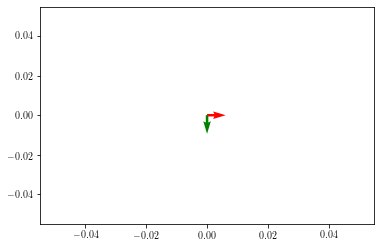

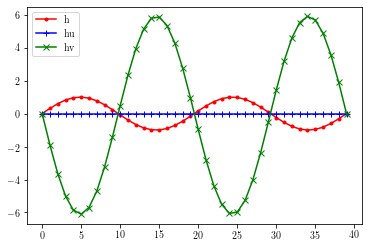

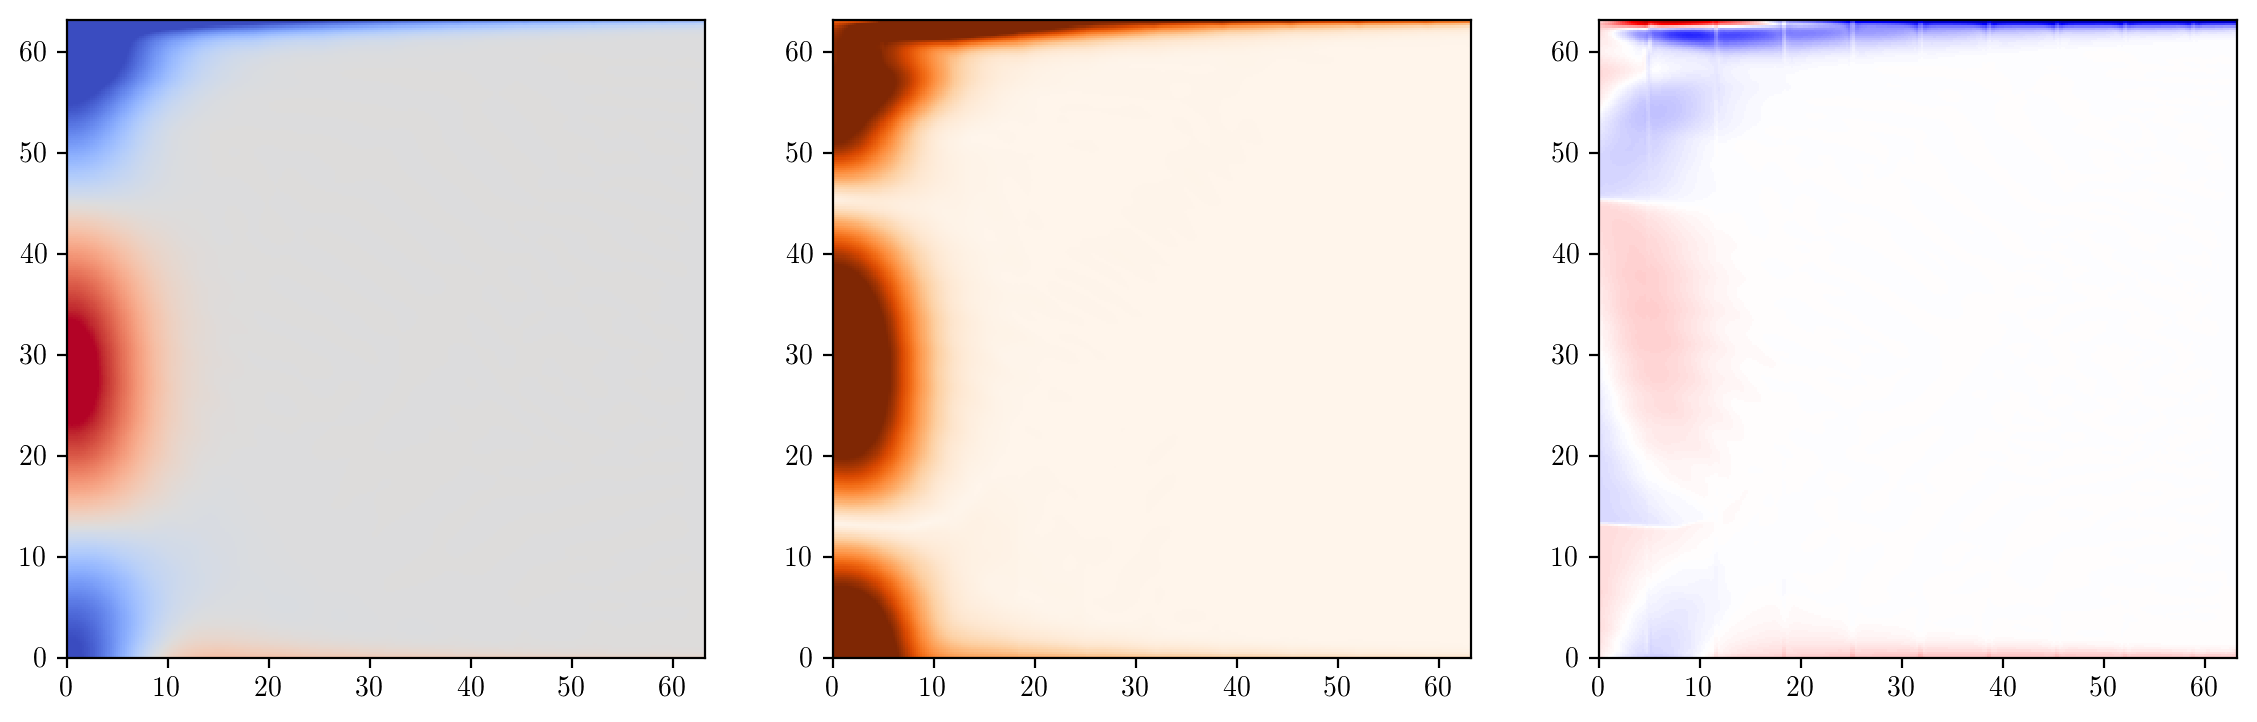

In [29]:
angle_to_north = np.pi/2
angle = np.array([[angle_to_north]], dtype=np.float32)

north = np.array([np.sin(angle_to_north), np.cos(angle_to_north)])
east = np.array([np.cos(angle_to_north), -np.sin(angle_to_north)])
up = np.array([-np.sin(angle_to_north), np.cos(angle_to_north)])
right = np.array([np.cos(angle_to_north), np.sin(angle_to_north)])

plt.figure()
plt.quiver(north[0], north[1], color='r')
plt.quiver(east[0], east[1], color='g')

sponge_cells=[10, 10, 10, 10]
bc_len = 40
H_max = 60

t = []
h_ns = []
hu_ns = []
hv_ns = []

h_ew = []
hu_ew = []
hv_ew = []


plt.figure()
t_end = 5000
for i in range(bc_len):
    j = i / (bc_len-1)

    eps = np.ones((1, 2), dtype=np.float32)*np.sin(4*np.pi*j)
    #eps[0, 1] = eps[0, 1] * 0.2;
    zero = np.zeros((1, 2), dtype=np.float32)

    t = t + [500+j*t_end]
    h = eps
    h_ns = h_ns + [h]
    h_ew = h_ew + [np.transpose(h)]
    
    hu_east = eps*0.1*(H_max+eps)
    hv_north = zero
    
    hu = hu_east*right[0] + hv_north*right[1]
    hv = hu_east*up[0] + hv_north*up[1]
    
    hu_ns = hu_ns + [hu]
    hu_ew = hu_ew + [np.transpose(hu)]
    
    hv_ns = hv_ns + [hv]
    hv_ew = hv_ew + [np.transpose(hv)]
    
    
plt.plot(np.array(h_ns)[:,0, 0], 'r.-', label='h')
plt.plot(np.array(hu_ns)[:,0, 0], 'b+-', label='hu')
plt.plot(np.array(hv_ns)[:,0, 0], 'gx-', label='hv')
plt.legend()
plt.show()

h_north = h_ns
h_south = [np.zeros((1, 2), dtype=np.float32)]*bc_len
h_east = [np.zeros((2, 1), dtype=np.float32)]*bc_len
h_west = [np.zeros((2, 1), dtype=np.float32)]*bc_len

hu_north = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hu_south = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hu_east = [np.zeros((2, 1), dtype=np.float32)]*bc_len
hu_west = [np.zeros((2, 1), dtype=np.float32)]*bc_len

hv_north = hv_ns
hv_south = hv_ns
hv_east = [np.zeros((2, 1), dtype=np.float32)]*bc_len
hv_west = [np.zeros((2, 1), dtype=np.float32)]*bc_len


boundary_conditions = Common.BoundaryConditions(north=3,south=3,east=1,west=1, spongeCells=sponge_cells)

bc_north = Common.SingleBoundaryConditionData(h_north, hu_north, hv_north);
bc_south = Common.SingleBoundaryConditionData(h_south, hu_south, hv_south);
bc_east = Common.SingleBoundaryConditionData(h_east, hu_east, hv_east);
bc_west = Common.SingleBoundaryConditionData(h_west, hu_west, hv_west);
boundary_conditions_data = Common.BoundaryConditionsData(t, bc_north, bc_south, bc_east, bc_west)

importlib.reload(Common)
importlib.reload(CDKLM16)


# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 300, "ny": 300,
    "dx": 200.0, "dy": 200.0,
    "dt": 1.0,
    "g": 9.81,
    "f": 0.0012,
    "coriolis_beta": 1.0e-6,
    "f": 0.0,
    "r": 0.0,
    "rk_order": 2
}


dataShape = (sim_args['ny'] + sponge_cells[0]+sponge_cells[2], 
             sim_args['nx'] + sponge_cells[1]+sponge_cells[3])
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_max
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)
#addCentralBump(eta0, sim_args['nx'], sim_args['ny'], sim_args['dx'], sim_args['dy'], sponge_cells)



#Initialize simulator
data_args = {"H": H, 
             "eta0": eta0, 
             "hu0": u0, 
             "hv0": v0,
             "angle": angle,
             "boundary_conditions": boundary_conditions,
             "boundary_conditions_data": boundary_conditions_data
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)

#Run a simulation and plot it
sim_animation(sim, t_end=2*t_end, T=20, h_max=0.7, h_min=-0.7, uv_max=0.1, uv_min=-0.1, 
              create_movie=create_movie, fig=plt.figure(figsize=(14,8), dpi=200), filename='east.pdf')

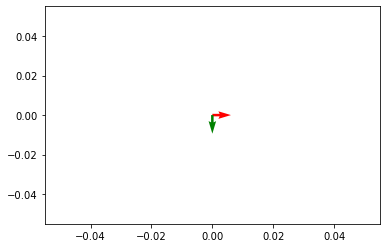

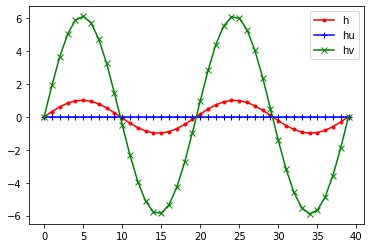

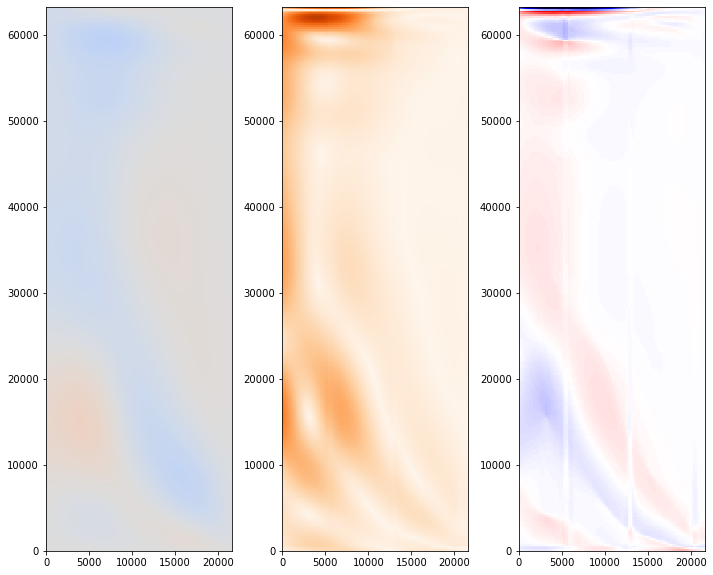

In [10]:
angle_to_north = np.pi/2
angle = np.array([[angle_to_north]], dtype=np.float32)

north = np.array([np.sin(angle_to_north), np.cos(angle_to_north)])
east = np.array([np.cos(angle_to_north), -np.sin(angle_to_north)])
up = np.array([-np.sin(angle_to_north), np.cos(angle_to_north)])
right = np.array([np.cos(angle_to_north), np.sin(angle_to_north)])

plt.figure()
plt.quiver(north[0], north[1], color='r')
plt.quiver(east[0], east[1], color='g')

sponge_cells=[10, 10, 10, 10]
bc_len = 40
H_max = 60

t = []
h_ns = []
hu_ns = []
hv_ns = []

h_ew = []
hu_ew = []
hv_ew = []


plt.figure()
t_end = 5000
for i in range(bc_len):
    j = i / (bc_len-1)

    eps = np.ones((1, 2), dtype=np.float32)*np.sin(4*np.pi*j)
    #eps[0, 1] = eps[0, 1] * 0.2;
    zero = np.zeros((1, 2), dtype=np.float32)

    t = t + [500+j*t_end]
    h = eps
    h_ns = h_ns + [h]
    h_ew = h_ew + [np.transpose(h)]
    
    hu_east = eps*0.1*(H_max+eps)
    hv_north = zero
    
    hu = hu_east*right[0] + hv_north*right[1]
    hv = hu_east*up[0] + hv_north*up[1]
    
    hu_ns = hu_ns + [-hu]
    hu_ew = hu_ew + [np.transpose(hu)]
    
    hv_ns = hv_ns + [-hv]
    hv_ew = hv_ew + [np.transpose(hv)]
    
    
plt.plot(np.array(h_ns)[:,0, 0], 'r.-', label='h')
plt.plot(np.array(hu_ns)[:,0, 0], 'b+-', label='hu')
plt.plot(np.array(hv_ns)[:,0, 0], 'gx-', label='hv')
plt.legend()
plt.show()

h_north = [np.zeros((1, 2), dtype=np.float32)]*bc_len
h_south = h_ns
h_east = [np.zeros((2, 1), dtype=np.float32)]*bc_len
h_west = [np.zeros((2, 1), dtype=np.float32)]*bc_len

hu_north = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hu_south = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hu_east = [np.zeros((2, 1), dtype=np.float32)]*bc_len
hu_west = [np.zeros((2, 1), dtype=np.float32)]*bc_len

hv_north = hv_ns
hv_south = hv_ns
hv_east = [np.zeros((2, 1), dtype=np.float32)]*bc_len
hv_west = [np.zeros((2, 1), dtype=np.float32)]*bc_len


boundary_conditions = Common.BoundaryConditions(north=3,south=3,east=1,west=1, spongeCells=sponge_cells)

bc_north = Common.SingleBoundaryConditionData(h_north, hu_north, hv_north);
bc_south = Common.SingleBoundaryConditionData(h_south, hu_south, hv_south);
bc_east = Common.SingleBoundaryConditionData(h_east, hu_east, hv_east);
bc_west = Common.SingleBoundaryConditionData(h_west, hu_west, hv_west);
boundary_conditions_data = Common.BoundaryConditionsData(t, bc_north, bc_south, bc_east, bc_west)

importlib.reload(Common)
importlib.reload(CDKLM16)


# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 92, "ny": 300,
    "dx": 200.0, "dy": 200.0,
    "dt": 1.0,
    "g": 9.81,
    "f": 0.0012,
    "coriolis_beta": 1.0e-6,
    "f": 0.0,
    "r": 0.0,
    "rk_order": 2
}


dataShape = (sim_args['ny'] + sponge_cells[0]+sponge_cells[2], 
             sim_args['nx'] + sponge_cells[1]+sponge_cells[3])
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_max
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)
#addCentralBump(eta0, sim_args['nx'], sim_args['ny'], sim_args['dx'], sim_args['dy'], sponge_cells)



#Initialize simulator
data_args = {"H": H, 
             "eta0": eta0, 
             "hu0": u0, 
             "hv0": v0,
             "angle": angle,
             "boundary_conditions": boundary_conditions,
             "boundary_conditions_data": boundary_conditions_data
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)

#Run a simulation and plot it
sim_animation(sim, t_end=4*t_end, T=40, h_max=0.7, h_min=-0.7, uv_max=0.1, uv_min=-0.1, create_movie=create_movie, fig=plt.figure(figsize=(12,10)))

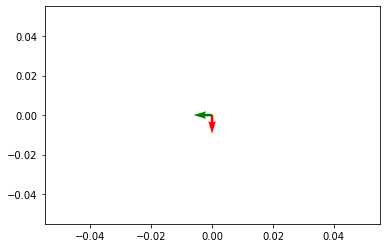

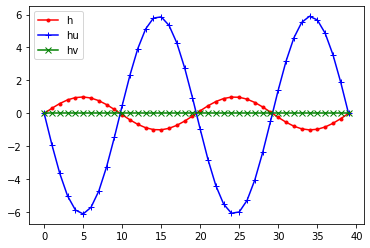

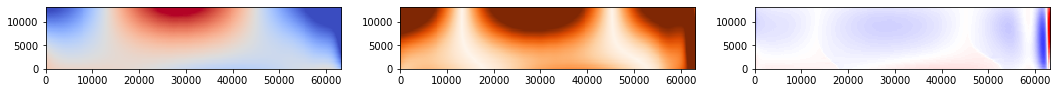

In [11]:
angle_to_north = np.pi
angle = np.array([[angle_to_north]], dtype=np.float32)

north = np.array([np.sin(angle_to_north), np.cos(angle_to_north)])
east = np.array([np.cos(angle_to_north), -np.sin(angle_to_north)])

plt.figure()
plt.quiver(north[0], north[1], color='r')
plt.quiver(east[0], east[1], color='g')

sponge_cells=[10, 10, 10, 10]
bc_len = 40
H_max = 60

t = []
h_ns = []
hu_ns = []
hv_ns = []

h_ew = []
hu_ew = []
hv_ew = []


plt.figure()
t_end = 5000
for i in range(bc_len):
    j = i / (bc_len-1)

    eps = np.ones((1, 2), dtype=np.float32)*np.sin(4*np.pi*j)
    #eps[0, 1] = eps[0, 1] * 0.2;
    zero = np.zeros((1, 2), dtype=np.float32)

    t = t + [500+j*t_end]
    h = eps
    h_ns = h_ns + [h]
    h_ew = h_ew + [np.transpose(h)]
    
    hu_east = eps*0.1*(H_max+eps)
    hv_north = zero
    
    hu = hu_east*east[0] + hv_north*east[1]
    hv = hu_east*north[0] + hv_north*north[1]
    
    hu_ns = hu_ns + [hu]
    hu_ew = hu_ew + [np.transpose(hu)]
    
    hv_ns = hv_ns + [hv]
    hv_ew = hv_ew + [np.transpose(hv)]
    
    
plt.plot(np.array(h_ew)[:,0, 0], 'r.-', label='h')
plt.plot(np.array(hu_ew)[:,0, 0], 'b+-', label='hu')
plt.plot(np.array(hv_ew)[:,0, 0], 'gx-', label='hv')
plt.legend()
plt.show()

h_north = [np.zeros((1, 2), dtype=np.float32)]*bc_len
h_south = [np.zeros((1, 2), dtype=np.float32)]*bc_len
h_east = h_ew
h_west = [np.zeros((2, 1), dtype=np.float32)]*bc_len

hu_north = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hu_south = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hu_east = hu_ew
hu_west = hu_ew

hv_north = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hv_south = [np.zeros((1, 2), dtype=np.float32)]*bc_len
hv_east = [np.zeros((2, 1), dtype=np.float32)]*bc_len
hv_west = [np.zeros((2, 1), dtype=np.float32)]*bc_len

boundary_conditions = Common.BoundaryConditions(north=1,south=1,east=3,west=3, spongeCells=sponge_cells)

bc_north = Common.SingleBoundaryConditionData(h_north, hu_north, hv_north);
bc_south = Common.SingleBoundaryConditionData(h_south, hu_south, hv_south);
bc_east = Common.SingleBoundaryConditionData(h_east, hu_east, hv_east);
bc_west = Common.SingleBoundaryConditionData(h_west, hu_west, hv_west);
boundary_conditions_data = Common.BoundaryConditionsData(t, bc_north, bc_south, bc_east, bc_west)

importlib.reload(Common)
importlib.reload(CDKLM16)


# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 300, "ny": 50,
    "dx": 200.0, "dy": 200.0,
    "dt": 1.0,
    "g": 9.81,
    "f": 0.0012,
    "coriolis_beta": 1.0e-6,
    "r": 0.0,
    "rk_order": 2
}

# Correcting f according to y_0:
sim_args['f'] = sim_args['f'] + sim_args['ny']*sim_args['coriolis_beta']*sim_args['dy']

dataShape = (sim_args['ny'] + sponge_cells[0]+sponge_cells[2], 
             sim_args['nx'] + sponge_cells[1]+sponge_cells[3])
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * H_max
eta0 = np.zeros(dataShape, dtype=np.float32)
u0 = np.zeros(dataShape, dtype=np.float32)
v0 = np.zeros(dataShape, dtype=np.float32)
#addCentralBump(eta0, sim_args['nx'], sim_args['ny'], sim_args['dx'], sim_args['dy'], sponge_cells)



#Initialize simulator
data_args = {"H": H, 
             "eta0": eta0, 
             "hu0": u0, 
             "hv0": v0,
             "angle": angle,
             "boundary_conditions": boundary_conditions,
             "boundary_conditions_data": boundary_conditions_data
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)

#Run a simulation and plot it
sim_animation(sim, t_end=2*t_end, T=20, h_max=0.7, h_min=-0.7, uv_max=0.1, uv_min=-0.1, create_movie=create_movie, fig=plt.figure(figsize=(18,2)))